In [1]:
# import libaries

from PIL import Image
from tqdm.notebook import tqdm
import numpy as np
import random
import sys
import pandas as pd
import matplotlib.pyplot as plt

from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler
from torchinfo import summary
from torchvision import transforms
from torch import optim
import torch
import torch.nn as nn
import torch.nn.functional as F

from sklearn.model_selection import KFold

In [2]:
print('Python version:', sys.version)
print('CUDA Available:', torch.cuda.is_available())

if torch.cuda.is_available():
    print('GPU Name:', torch.cuda.get_device_name())
    print('GPU Properties:\n', torch.cuda.get_device_properties('cuda'))
    device = "cuda"
    torch.cuda.set_per_process_memory_fraction(0.95, 0)
    torch.cuda.empty_cache()
else:
    print("Cuda is not available, please use cpu instead")
    device = "cpu"
!nvidia-smi

Python version: 3.9.0 (tags/v3.9.0:9cf6752, Oct  5 2020, 15:34:40) [MSC v.1927 64 bit (AMD64)]
CUDA Available: True
GPU Name: NVIDIA GeForce RTX 2070
GPU Properties:
 _CudaDeviceProperties(name='NVIDIA GeForce RTX 2070', major=7, minor=5, total_memory=8191MB, multi_processor_count=36)
Sat Feb 18 11:47:29 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 526.98       Driver Version: 526.98       CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ... WDDM  | 00000000:01:00.0  On |                  N/A |
|  0%   40C    P2    48W / 175W |    966Mi

In [3]:
seed = 41
# Define custom dataset
class FaceDataset(Dataset):
    def __init__(self, df = None, num_sample = None, transform = None, num_img_pool = 10):
        # set random seed for FaceDataset
        np.random.seed(seed)
        random.seed(seed)
        # create constructors
        self.unique_img_name = None
        self.data = dict()
        self.images = list()
        # label to indices
        self.label_to_indices = dict()
        self.labels = list()
        # read csv file
        self.df = df
        # set the transformation
        self.transform = transform
        # drop last n row from dataframe
        self.df = self.df.head(num_sample)
        #get the length of entire dataset
        self.len_ = len(self.df)
        # load imgs
        self.load_imgs(self.df, num_imgs = num_img_pool, max = num_sample)

    def __len__(self):
        return self.len_

    # get each pair of images -> 1: same identity, 0: different identity 
    # if index is even -> same pair 
    # if index is odd -> random identity
    def __getitem__(self, idx):
        anchor_img = self.images[idx]
        anchor_label = self.labels[idx]

        pos_idx = np.random.choice(np.arange(len(self.images))[self.labels == anchor_label])
        neg_idx = np.random.choice(np.arange(len(self.images))[self.labels != anchor_label])

        pos_img = self.images[pos_idx]
        neg_img = self.images[neg_idx]

        pos_label = self.labels[pos_idx]
        neg_label = self.labels[neg_idx]

        if self.transform is None:
            img_to_tensor = transforms.ToTensor()
            anchor_img = img_to_tensor(anchor_img)
            pos_img = img_to_tensor(pos_img)
            neg_img = img_to_tensor(neg_img)
        else:
            anchor_img = self.transform(anchor_img)
            pos_img = self.transform(pos_img)
            neg_img = self.transform(neg_img)

        return anchor_img, pos_img, neg_img

    # load imgs from pandas to memory and define the maximum number of images
    def load_imgs(self, df, num_imgs, max):
        # iterate thought each row
        for i, row in tqdm(df.iterrows(), total = max):
            # get identity of each row
            row_identity = row['identity']
            # append each identity to numberical value
            self.label_to_indices[int(row_identity)] = i
            count_img = 0
            # loop imgs in each identity
            for img_name in row['path']:
                if count_img > num_imgs:
                    break
                # concatenate the directoru and image name
                # path_to_image = self.dir+img_name
                path_to_image = img_name
                # open image and convert to RGB
                img = Image.open(path_to_image).convert('RGB')

                self.images.append(img)
                self.labels.append(i)
                count_img += 1
            # print('Added img '+ str(row_identity))
        self.labels = np.array(self.labels)

# Preperation of dataset

In [4]:
ds_df = pd.read_csv('./digiface_csv_files/digi_all.csv')
ds_df = ds_df.groupby('identity')['path'].apply(list).reset_index()
ds_df

,identity,path
0,0,"[digiFace1M\subjects_0-1999_72_imgs\0\20.png, ..."
1,1,"[digiFace1M\subjects_0-1999_72_imgs\1\66.png, ..."
2,2,"[digiFace1M\subjects_0-1999_72_imgs\2\29.png, ..."
3,3,"[digiFace1M\subjects_0-1999_72_imgs\3\42.png, ..."
4,4,"[digiFace1M\subjects_0-1999_72_imgs\4\33.png, ..."
...,...,...
72661,199994,[digiFace1M\subjects_166666-199998_5_imgs\1999...
72662,199995,[digiFace1M\subjects_166666-199998_5_imgs\1999...
72663,199996,[digiFace1M\subjects_166666-199998_5_imgs\1999...
72664,199997,[digiFace1M\subjects_166666-199998_5_imgs\1999...


In [5]:
from sklearn.model_selection import train_test_split

# splitting each dataset
train_df, eval_df = train_test_split(ds_df, test_size= 0.3, shuffle = True, random_state = seed)
val_df, test_df = train_test_split(eval_df, test_size = 0.4, shuffle = True, random_state = seed)

# print to check size of each dataset
print(f'Train Size: {len(train_df)}')
print(f'Val Size: {len(val_df)}')
print(f'Test Size: {len(test_df)}')

train_df.head(5)

Train Size: 50866
Val Size: 13080
Test Size: 8720


,identity,path
26344,120344,[digiFace1M\subjects_100000-133332_5_imgs\1203...
61833,189166,[digiFace1M\subjects_166666-199998_5_imgs\1891...
46921,174254,[digiFace1M\subjects_166666-199998_5_imgs\1742...
4873,8873,[digiFace1M\subjects_8000-9999_72_imgs\8873\54...
19875,113875,[digiFace1M\subjects_100000-133332_5_imgs\1138...


In [6]:
# define image size
img_size = 112

# define transformation for test set
train_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.CenterCrop(img_size),
    transforms.RandomHorizontalFlip(p=0.6),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])


# define transformation for validation set
val_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.CenterCrop(img_size),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])


# define batch size
train_batch_size = 64
val_batch_size = 64
print('------------Started Loading Train Set------------')
# create dataloader for train set
train_triplet_dataset = FaceDataset(df = train_df, num_sample = 6000, transform = train_transform)
train_triplet_dataloader = DataLoader(train_triplet_dataset, batch_size=train_batch_size, shuffle=True, pin_memory=True)
print('Total Train Set: ', train_triplet_dataset.__len__())
print('-----------Finished Loading Train Set------------')

print('\n')

print('------------Started Loading Validation Set------------')
# create dataloader for validation set
val_triplet_dataset = FaceDataset(df = val_df,num_sample = 3000, transform = val_transform)
val_triplet_dataloader = DataLoader(val_triplet_dataset, batch_size=val_batch_size, shuffle=True, pin_memory=True)
print('Total Train Set: ', val_triplet_dataset.__len__())
print('-----------Finished Loading Validation Set------------')


------------Started Loading Train Set------------


  0%|          | 0/6000 [00:00<?, ?it/s]

Total Train Set:  6000
-----------Finished Loading Train Set------------


------------Started Loading Validation Set------------


  0%|          | 0/3000 [00:00<?, ?it/s]

Total Train Set:  3000
-----------Finished Loading Validation Set------------


In [7]:
len(val_triplet_dataloader)

47

# Triplet Network

In [8]:
from torch.nn import Linear, Conv2d, BatchNorm1d, BatchNorm2d, PReLU, ReLU, ReLU6, Sigmoid, Dropout2d\
    ,Dropout, AvgPool2d, MaxPool2d, AdaptiveAvgPool2d, Sequential, Module, Parameter

class Flatten(Module):
    def forward(self, input):
        return input.view(input.size(0), -1)

def l2_norm(input,axis=1):
    norm = torch.norm(input,2,axis,True)
    output = torch.div(input, norm)
    return output

class h_sigmoid(Module):
    def __init__(self, inplace=True):
        super(h_sigmoid, self).__init__()
        self.relu = ReLU6(inplace=inplace)

    def forward(self, x):
        return self.relu(x + 3) / 6


class h_swish(Module):
    def __init__(self, inplace=True):
        super(h_swish, self).__init__()
        self.sigmoid = h_sigmoid(inplace=inplace)

    def forward(self, x):
        return x * self.sigmoid(x)


class SELayer(Module):
    def __init__(self, channel, reduction=4):
        super(SELayer, self).__init__()
        self.avg_pool = AdaptiveAvgPool2d(1)
        self.fc = Sequential(
            Linear(channel, channel // reduction),
            ReLU(inplace=True),
            Linear(channel // reduction, channel),
            h_sigmoid()
        )

    def forward(self, x):
        b, c, _, _ = x.size()
        y = self.avg_pool(x).view(b, c)
        y = self.fc(y).view(b, c, 1, 1)
        return x * y

class PermutationBlock(Module):
    def __init__(self, groups):
        super(PermutationBlock, self).__init__()
        self.groups = groups

    def forward(self, input):
        n, c, h, w = input.size()
        G = self.groups
        output = input.view(n, G, c // G, h, w).permute(0, 2, 1, 3, 4).contiguous().view(n, c, h, w)
        return output

class Conv_block(Module):
    def __init__(self, in_c, out_c, kernel=(1, 1), stride=(1, 1), padding=(0, 0), groups=1):
        super(Conv_block, self).__init__()
        self.conv = Conv2d(in_c, out_channels=out_c, kernel_size=kernel, groups=groups, stride=stride, padding=padding, bias=False)
        self.bn = BatchNorm2d(out_c)
        self.prelu = PReLU(out_c)
    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        x = self.prelu(x)
        return x

class Linear_block(Module):
    def __init__(self, in_c, out_c, kernel=(1, 1), stride=(1, 1), padding=(0, 0), groups=1):
        super(Linear_block, self).__init__()
        self.conv = Conv2d(in_c, out_channels=out_c, kernel_size=kernel, groups=groups, stride=stride, padding=padding, bias=False)
        self.bn = BatchNorm2d(out_c)
    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        return x

class Depth_Wise(Module):
    def __init__(self, in_c, out_c, residual = False, kernel=(3, 3), stride=(2, 2), padding=(1, 1), groups=1):
        super(Depth_Wise, self).__init__()
        self.conv = Conv_block(in_c, out_c=groups, kernel=(1, 1), padding=(0, 0), stride=(1, 1))
        self.conv_dw = Conv_block(groups, groups, groups=groups, kernel=kernel, padding=padding, stride=stride)
        self.project = Linear_block(groups, out_c, kernel=(1, 1), padding=(0, 0), stride=(1, 1))
        self.residual = residual
    def forward(self, x):
        if self.residual:
            short_cut = x
        x = self.conv(x)
        x = self.conv_dw(x)
        x = self.project(x)
        if self.residual:
            output = short_cut + x
        else:
            output = x
        return output

class Residual(Module):
    def __init__(self, c, num_block, groups, kernel=(3, 3), stride=(1, 1), padding=(1, 1)):
        super(Residual, self).__init__()
        modules = []
        for _ in range(num_block):
            modules.append(Depth_Wise(c, c, residual=True, kernel=kernel, padding=padding, stride=stride, groups=groups))
        self.model = Sequential(*modules)
    def forward(self, x):
        return self.model(x)

class LinearScheduler(nn.Module):
    def __init__(self, dropblock, start_value, stop_value, nr_steps):
        super(LinearScheduler, self).__init__()
        self.dropblock = dropblock
        self.i = 0
        self.drop_values = np.linspace(start=start_value, stop=stop_value, num=nr_steps)

    def forward(self, x):
        return self.dropblock(x)

    def step(self):
        if self.i < len(self.drop_values):
            self.dropblock.drop_prob = self.drop_values[self.i]

        self.i += 1

class DropBlock2D(nn.Module):
    r"""Randomly zeroes 2D spatial blocks of the input tensor.
    As described in the paper
    `DropBlock: A regularization method for convolutional networks`_ ,
    dropping whole blocks of feature map allows to remove semantic
    information as compared to regular dropout.
    Args:
        drop_prob (float): probability of an element to be dropped.
        block_size (int): size of the block to drop
    Shape:
        - Input: `(N, C, H, W)`
        - Output: `(N, C, H, W)`
    .. _DropBlock: A regularization method for convolutional networks:
       https://arxiv.org/abs/1810.12890
    """

    def __init__(self, drop_prob, block_size):
        super(DropBlock2D, self).__init__()

        self.drop_prob = drop_prob
        self.block_size = block_size

    def forward(self, x):
        # shape: (bsize, channels, height, width)

        assert x.dim() == 4, \
            "Expected input with 4 dimensions (bsize, channels, height, width)"

        if not self.training or self.drop_prob == 0.:
            return x
        else:
            # get gamma value
            gamma = self._compute_gamma(x)

            # sample mask
            mask = (torch.rand(x.shape[0], *x.shape[2:]) < gamma).float()

            # place mask on input device
            mask = mask.to(x.device)

            # compute block mask
            block_mask = self._compute_block_mask(mask)

            # apply block mask
            out = x * block_mask[:, None, :, :]

            # scale output
            out = out * block_mask.numel() / block_mask.sum()

            return out

    def _compute_block_mask(self, mask):
        block_mask = F.max_pool2d(input=mask[:, None, :, :],
                                  kernel_size=(self.block_size, self.block_size),
                                  stride=(1, 1),
                                  padding=self.block_size // 2)

        if self.block_size % 2 == 0:
            block_mask = block_mask[:, :, :-1, :-1]

        block_mask = 1 - block_mask.squeeze(1)

        return block_mask

    def _compute_gamma(self, x):
        return self.drop_prob / (self.block_size ** 2)


In [9]:

class MobileFaceNet(Module):
    def __init__(self, embedding_size=512):
        super(MobileFaceNet, self).__init__()
        self.conv1 = Conv_block(3, 64, kernel=(3, 3), stride=(2, 2), padding=(1, 1))
        self.conv2_dw = Conv_block(64, 64, kernel=(3, 3), stride=(1, 1), padding=(1, 1), groups=64)
        self.conv_23 = Depth_Wise(64, 64, kernel=(3, 3), stride=(2, 2), padding=(1, 1), groups=128)
        self.conv_3 = Residual(64, num_block=4, groups=128, kernel=(3, 3), stride=(1, 1), padding=(1, 1))
        self.conv_34 = Depth_Wise(64, 128, kernel=(3, 3), stride=(2, 2), padding=(1, 1), groups=256)
        self.conv_4 = Residual(128, num_block=6, groups=256, kernel=(3, 3), stride=(1, 1), padding=(1, 1))
        self.conv_45 = Depth_Wise(128, 128, kernel=(3, 3), stride=(2, 2), padding=(1, 1), groups=512)
        self.conv_5 = Residual(128, num_block=2, groups=256, kernel=(3, 3), stride=(1, 1), padding=(1, 1))
        self.conv_6_sep = Conv_block(128, 512, kernel=(1, 1), stride=(1, 1), padding=(0, 0))
        self.conv_6_dw = Linear_block(512, 512, groups=512, kernel=(7,7), stride=(1, 1), padding=(0, 0))
        self.conv_6_flatten = Flatten()
        self.linear = Linear(512, embedding_size, bias=False)
        self.bn = BatchNorm1d(embedding_size)
        self.dropblock = DropBlock2D(block_size=3, drop_prob=0.3)
        self.dropout = Dropout2d(0.3)

    def forward_once(self,x):
        out = self.conv1(x)

        out = self.conv2_dw(out)

        out = self.conv_23(out)

        out = self.conv_3(out)

        out = self.conv_34(out)

        out = self.conv_4(out)

        # out = self.dropblock(out)

        out = self.conv_45(out)

        out = self.conv_5(out)

        out = self.conv_6_sep(out)

        out = self.dropblock(out)

        out = self.conv_6_dw(out)

        out = self.dropblock(out)

        out = self.conv_6_flatten(out)

        out = self.linear(out)

        out = self.bn(out)
        return l2_norm(out)

    def forward(self, anchor_img, positive_img, negative_img):
        anchor = self.forward_once(anchor_img)
        positive = self.forward_once(positive_img)
        negative = self.forward_once(negative_img)
        return anchor, positive, negative


In [10]:
# triplet_model = TripletNetwork()
triplet_model = MobileFaceNet()
print(summary(triplet_model, input_size=[(32,3,112,112),(32,3,112,112),(32,3,112,112)]))

Layer (type:depth-idx)                        Output Shape              Param #
MobileFaceNet                                 [32, 512]                 --
├─Conv_block: 1-1                             [32, 64, 56, 56]          --
│    └─Conv2d: 2-1                            [32, 64, 56, 56]          1,728
│    └─BatchNorm2d: 2-2                       [32, 64, 56, 56]          128
│    └─PReLU: 2-3                             [32, 64, 56, 56]          64
├─Conv_block: 1-2                             [32, 64, 56, 56]          --
│    └─Conv2d: 2-4                            [32, 64, 56, 56]          576
│    └─BatchNorm2d: 2-5                       [32, 64, 56, 56]          128
│    └─PReLU: 2-6                             [32, 64, 56, 56]          64
├─Depth_Wise: 1-3                             [32, 64, 28, 28]          --
│    └─Conv_block: 2-7                        [32, 128, 56, 56]         --
│    │    └─Conv2d: 3-1                       [32, 128, 56, 56]         8,192
│    │    └

In [11]:
import math
class Arcface(Module):
    # implementation of additive margin softmax loss in https://arxiv.org/abs/1801.05599
    def __init__(self, embedding_size=512,  classnum=51332,  s=64., m=0.5):
        super(Arcface, self).__init__()
        self.classnum = classnum
        self.kernel = Parameter(torch.Tensor(embedding_size,classnum))
        # initial kernel
        self.kernel.data.uniform_(-1, 1).renorm_(2,1,1e-5).mul_(1e5)
        self.m = m # the margin value, default is 0.5
        self.s = s # scalar value default is 64, see normface https://arxiv.org/abs/1704.06369
        self.cos_m = math.cos(m)
        self.sin_m = math.sin(m)
        self.mm = self.sin_m * m  # issue 1
        self.threshold = math.cos(math.pi - m)
        print('Arcface head')

    def forward(self, embbedings, label):
        # weights norm
        nB = len(embbedings)
        kernel_norm = l2_norm(self.kernel,axis=0)
        # cos(theta+m)
        cos_theta = torch.mm(embbedings,kernel_norm)
#         output = torch.mm(embbedings,kernel_norm)
        cos_theta = cos_theta.clamp(-1,1) # for numerical stability
        cos_theta_2 = torch.pow(cos_theta, 2)
        sin_theta_2 = 1 - cos_theta_2
        sin_theta = torch.sqrt(sin_theta_2)
        cos_theta_m = (cos_theta * self.cos_m - sin_theta * self.sin_m)
        # this condition controls the theta+m should in range [0, pi]
        #      0<=theta+m<=pi
        #     -m<=theta<=pi-m
        cond_v = cos_theta - self.threshold
        cond_mask = cond_v <= 0
        keep_val = (cos_theta - self.mm) # when theta not in [0,pi], use cosface instead
        cos_theta_m[cond_mask] = keep_val[cond_mask]
        output = cos_theta * 1.0 # a little bit hacky way to prevent in_place operation on cos_theta
        idx_ = torch.arange(0, nB, dtype=torch.long)
        output[idx_, label] = cos_theta_m[idx_, label]
        output *= self.s # scale up in order to make softmax work, first introduced in normface
        return output

In [12]:
class TripletLoss(nn.Module):
    def __init__(self, margin):
        super(TripletLoss, self).__init__()
        self.margin = margin

    def forward(self, anchor, positive, negative, size_average=True):
        # calculate Euclidean's distance
        distance_positive = (anchor - positive).pow(2).sum(1)
        distance_negative = (anchor - negative).pow(2).sum(1)
        # distance_positive = F.pairwise_distance(anchor, positive).view((-1, 1))
        # distance_negative = F.pairwise_distance(anchor, negative).view((-1, 1))
        losses = F.relu(distance_positive - distance_negative + self.margin)
        return torch.mean(losses)

In [13]:
class EarlyStopping:
    def __init__(self, patient=5, min_delta=0):

        self.patient = patient
        self.min_delta = min_delta
        self.counter = 0
        self.early_stop = False

    def __call__(self, train_loss, validation_loss):
        if (validation_loss - train_loss) > self.min_delta:
            self.counter +=1
            if self.counter >= self.patient:
                self.early_stop = True

    def check_early_stop(self):
        return self.early_stop

In [14]:
def calculate_accuracy(threshold, dist, actual_issame):
    predict_issame = np.less(dist, threshold)
    tp = np.sum(np.logical_and(predict_issame, actual_issame))
    tn = np.sum(np.logical_and(np.logical_not(predict_issame), np.logical_not(actual_issame)))

    acc = float(tp + tn) / dist.size

    return acc

In [15]:
model_config = {
    'margin': 1.2,
    'lr': 1e-3,
    'patience': 5,
    'factor': 0.1,
    'min_lr': 1e-10,
    'threshold': 1e-3
}
criterion = TripletLoss(margin = model_config['margin'])
optimizer = optim.Adam(triplet_model.parameters(), lr=model_config['lr'])
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=model_config['patience'], factor=model_config['factor'], min_lr=model_config['min_lr'], threshold=model_config['threshold'], verbose=True)

# early_stop = EarlyStopping(patient=5, min_delta=0.001)

In [16]:
from sklearn.model_selection import KFold

split = 5
k_fold = KFold(n_splits = 5, shuffle = True)
# history_fold = {
#     avg
# }

In [17]:
def train_nn(load_weight_pth = None, save_weight_pth = None, num_epochs = 200 , load_weight = False):
    load_weight_path  = './weights/triplet_mobilenetwork_100_epochs_.pth' if (load_weight_pth == None) else load_weight_pth
    save_weight_path = './weights/triplet_mobilenetwork_200_epochs_.pth' if (load_weight_pth == None) else save_weight_pth

    # throw model to compute in the device
    triplet_model.to(device=device)
    total_train_loss = list()
    total_val_loss = list()

    total_train_acc = list()
    total_val_acc = list()

    best_val_loss = 0
    best_train_loss = 0
    previous_lr = 0

    # load weight
    if bool(load_weight_path) & load_weight:
        triplet_model.load_state_dict(torch.load(load_weight_path))
        print('Congratulations, Weight has been loaded!')

    # for fold, (train_ids, valid_ids) in enumerate(k_fold.splits(train_triplet_dataset)):
    #     print(f'Fold: {fold}')
    #     train_subsampler = SubsetRandomSampler(train_ids)
    #     val_subsampler = SubsetRandomSampler(valid_ids)
    #
    #     train_triplet_dataloader = DataLoader(train_triplet_dataset, batch_size=train_batch_size, shuffle=True, pin_memory=True)
    # iterate though each epoch
    for epoch in tqdm(range(num_epochs)):
        print(f'Epoch:{epoch+1}/{num_epochs}')
        # epoch_train_loss = list()
        epoch_train_acc = np.array([])
        # epoch_val_loss = list()
        epoch_val_acc = np.array([])

        train_loss = 0
        val_loss = 0

        # switch to train mode
        triplet_model.train()
        with torch.set_grad_enabled(True):
            # loop though each item in dataloader
            for anchor_img, pos_img, neg_img in tqdm(train_triplet_dataloader):

                threshold_list = np.full(anchor_img.shape[0], model_config['margin'])
                is_same = np.full(anchor_img.shape[0], 1)

                # throw img to compute in the device
                anchor_img = anchor_img.to(device)
                pos_img = pos_img.to(device)
                neg_img = neg_img.to(device)
                # clear gradient to prevent gradient vanish
                optimizer.zero_grad()
                # train model
                output1, output2, output3 = triplet_model(anchor_img, pos_img, neg_img)

                # cal distance positive
                distance_positive = (output1 - output2).pow(2).sum(1)
                # compute loss from criterion
                loss = criterion(output1, output2, output3)
                # backward propagate
                loss.backward()
                # update parameters
                optimizer.step()
                # append train loss to epoch_train_loss
                train_loss += loss.item() * anchor_img.size(0)

                epoch_train_acc = np.append(epoch_train_acc,[calculate_accuracy(threshold_list,distance_positive.cpu().data.numpy(),is_same)])

        # calculate loss
        current_train_loss = train_loss / len(train_triplet_dataloader.sampler)
        total_train_loss.append(current_train_loss)

        # switch mode to eval
        triplet_model.eval()
        with torch.no_grad():
            for anchor_img, pos_img, neg_img in val_triplet_dataloader:

                threshold_list = np.full(anchor_img.shape[0], model_config['margin'])
                is_same = np.full(anchor_img.shape[0], 1)

                # throw img to compute in the device
                anchor_img = anchor_img.to(device)
                pos_img = pos_img.to(device)
                neg_img = neg_img.to(device)
                # clear gradient to prevent gradient vanish
                optimizer.zero_grad()
                # compute the out in eval mode
                output1, output2, output3 = triplet_model(anchor_img, pos_img, neg_img)
                # cal distance positive
                distance_positive = (output1 - output2).pow(2).sum(1)
                # compute loss in eval mode
                loss = criterion(output1, output2, output3)
                # calculate loss for each feature
                val_loss += loss.item() * anchor_img.size(0)

                # epoch_val_acc.append(calculate_accuracy(threshold_list,distance_positive.cpu().data.numpy(),is_same)[0])
                epoch_val_acc = np.append(epoch_val_acc,[calculate_accuracy(threshold_list,distance_positive.cpu().data.numpy(),is_same)])

        # calculate loss for each batch
        current_val_loss = val_loss / len(val_triplet_dataloader.sampler)
        total_val_loss.append(current_val_loss)

        total_train_acc.append(epoch_train_acc.mean())
        total_val_acc.append(epoch_val_acc.mean())
    # get learning rate from model
        optim_lr = optimizer.param_groups[0]['lr']

        # append current validation loss to list
        if (best_val_loss == 0) | (best_train_loss == 0):
            best_val_loss = current_val_loss
            best_train_loss = current_train_loss

        # find the best val loss
        if best_val_loss >= current_val_loss:
            best_val_loss = current_val_loss

        # find the best train loss
        if best_train_loss >= current_train_loss:
            best_train_loss = current_train_loss

        print(f'train loss: {current_train_loss}')
        print(f'val loss: {current_val_loss}')
        print(f'Learning rate: {optim_lr:.8f}')
        print(f'acc train: {epoch_train_acc.mean()}')
        print(f'acc val: {epoch_val_acc.mean()}')
        if (optim_lr < previous_lr) | (optim_lr > previous_lr):
            print('LEARNING RATE HAS CHANGED!')
        print('-------------------------------------------------------------')

        # replace the previous lr with the current lr
        previous_lr = optim_lr
        scheduler.step(current_train_loss)

    print('Best Validation loss',best_val_loss)
    print('Best Train loss', best_train_loss)

    # save model weights
    torch.save(triplet_model.state_dict(), save_weight_path)
    torch.cuda.empty_cache()
    return total_train_loss, total_val_loss, total_train_acc, total_val_acc

In [18]:
total_train_loss, total_val_loss, total_train_acc, total_val_acc = train_nn(num_epochs=120)

  0%|          | 0/120 [00:00<?, ?it/s]

Epoch:1/120


  0%|          | 0/94 [00:00<?, ?it/s]

train loss: 0.7801557566324869
val loss: 0.5722194215456645
Learning rate: 0.00100000
acc train: 0.42774822695035464
acc val: 0.65625
LEARNING RATE HAS CHANGED!
-------------------------------------------------------------
Epoch:2/120


  0%|          | 0/94 [00:00<?, ?it/s]

train loss: 0.6131229261557262
val loss: 0.5439039573669434
Learning rate: 0.00100000
acc train: 0.6346963652482269
acc val: 0.7066394376899695
-------------------------------------------------------------
Epoch:3/120


  0%|          | 0/94 [00:00<?, ?it/s]

train loss: 0.5333196069399516
val loss: 0.526369498093923
Learning rate: 0.00100000
acc train: 0.6869459219858156
acc val: 0.7301006838905776
-------------------------------------------------------------
Epoch:4/120


  0%|          | 0/94 [00:00<?, ?it/s]

train loss: 0.5197906551361084
val loss: 0.4718895117441813
Learning rate: 0.00100000
acc train: 0.7077238475177305
acc val: 0.7616831306990882
-------------------------------------------------------------
Epoch:5/120


  0%|          | 0/94 [00:00<?, ?it/s]

train loss: 0.47430268017450966
val loss: 0.4468213476339976
Learning rate: 0.00100000
acc train: 0.7461768617021277
acc val: 0.7604958206686929
-------------------------------------------------------------
Epoch:6/120


  0%|          | 0/94 [00:00<?, ?it/s]

train loss: 0.4280830322901408
val loss: 0.450054496606191
Learning rate: 0.00100000
acc train: 0.770279255319149
acc val: 0.7809650455927052
-------------------------------------------------------------
Epoch:7/120


  0%|          | 0/94 [00:00<?, ?it/s]

train loss: 0.4136760705312093
val loss: 0.4082140560944875
Learning rate: 0.00100000
acc train: 0.7750443262411348
acc val: 0.8205262158054711
-------------------------------------------------------------
Epoch:8/120


  0%|          | 0/94 [00:00<?, ?it/s]

train loss: 0.4035920976003011
val loss: 0.3732845861911774
Learning rate: 0.00100000
acc train: 0.7711103723404256
acc val: 0.8189114741641337
-------------------------------------------------------------
Epoch:9/120


  0%|          | 0/94 [00:00<?, ?it/s]

train loss: 0.3923598749637604
val loss: 0.37618178041776024
Learning rate: 0.00100000
acc train: 0.7889516843971631
acc val: 0.8372435410334347
-------------------------------------------------------------
Epoch:10/120


  0%|          | 0/94 [00:00<?, ?it/s]

train loss: 0.3610591322580973
val loss: 0.35707572929064435
Learning rate: 0.00100000
acc train: 0.8211436170212766
acc val: 0.823518237082067
-------------------------------------------------------------
Epoch:11/120


  0%|          | 0/94 [00:00<?, ?it/s]

train loss: 0.36612494723002115
val loss: 0.36302090613047283
Learning rate: 0.00100000
acc train: 0.8145500886524822
acc val: 0.8251329787234043
-------------------------------------------------------------
Epoch:12/120


  0%|          | 0/94 [00:00<?, ?it/s]

train loss: 0.35498908440272015
val loss: 0.35379976717631023
Learning rate: 0.00100000
acc train: 0.8186502659574468
acc val: 0.8247530395136777
-------------------------------------------------------------
Epoch:13/120


  0%|          | 0/94 [00:00<?, ?it/s]

train loss: 0.3432457230091095
val loss: 0.3434874864419301
Learning rate: 0.00100000
acc train: 0.8265181737588652
acc val: 0.8375284954407295
-------------------------------------------------------------
Epoch:14/120


  0%|          | 0/94 [00:00<?, ?it/s]

train loss: 0.34718528620402017
val loss: 0.320593691666921
Learning rate: 0.00100000
acc train: 0.8254654255319149
acc val: 0.859375
-------------------------------------------------------------
Epoch:15/120


  0%|          | 0/94 [00:00<?, ?it/s]

train loss: 0.3303584086894989
val loss: 0.3423962609767914
Learning rate: 0.00100000
acc train: 0.836824024822695
acc val: 0.8560980243161095
-------------------------------------------------------------
Epoch:16/120


  0%|          | 0/94 [00:00<?, ?it/s]

train loss: 0.3172310891946157
val loss: 0.34814342482884725
Learning rate: 0.00100000
acc train: 0.8353834219858156
acc val: 0.8301196808510638
-------------------------------------------------------------
Epoch:17/120


  0%|          | 0/94 [00:00<?, ?it/s]

train loss: 0.32293004242579143
val loss: 0.30840102744102477
Learning rate: 0.00100000
acc train: 0.8410904255319149
acc val: 0.8598024316109423
-------------------------------------------------------------
Epoch:18/120


  0%|          | 0/94 [00:00<?, ?it/s]

train loss: 0.3130691033999125
val loss: 0.3184336893558502
Learning rate: 0.00100000
acc train: 0.8489583333333333
acc val: 0.8543408054711246
-------------------------------------------------------------
Epoch:19/120


  0%|          | 0/94 [00:00<?, ?it/s]

train loss: 0.3122010091940562
val loss: 0.31607683261235553
Learning rate: 0.00100000
acc train: 0.8519503546099291
acc val: 0.8491166413373861
-------------------------------------------------------------
Epoch:20/120


  0%|          | 0/94 [00:00<?, ?it/s]

train loss: 0.3026063058376312
val loss: 0.3045142794450124
Learning rate: 0.00100000
acc train: 0.8541666666666667
acc val: 0.8592800151975684
-------------------------------------------------------------
Epoch:21/120


  0%|          | 0/94 [00:00<?, ?it/s]

train loss: 0.29773126606146494
val loss: 0.32324108068148294
Learning rate: 0.00100000
acc train: 0.8537234042553191
acc val: 0.8580452127659575
-------------------------------------------------------------
Epoch:22/120


  0%|          | 0/94 [00:00<?, ?it/s]

train loss: 0.2955508728027344
val loss: 0.3105145506064097
Learning rate: 0.00100000
acc train: 0.8620899822695035
acc val: 0.8410904255319149
-------------------------------------------------------------
Epoch:23/120


  0%|          | 0/94 [00:00<?, ?it/s]

train loss: 0.29151117340723676
val loss: 0.30178650037447613
Learning rate: 0.00100000
acc train: 0.8601507092198583
acc val: 0.8540558510638298
-------------------------------------------------------------
Epoch:24/120


  0%|          | 0/94 [00:00<?, ?it/s]

train loss: 0.2851400605837504
val loss: 0.3076414773464203
Learning rate: 0.00100000
acc train: 0.8674645390070922
acc val: 0.854768237082067
-------------------------------------------------------------
Epoch:25/120


  0%|          | 0/94 [00:00<?, ?it/s]

train loss: 0.28840517059961956
val loss: 0.2985789713859558
Learning rate: 0.00100000
acc train: 0.8650265957446809
acc val: 0.853295972644377
-------------------------------------------------------------
Epoch:26/120


  0%|          | 0/94 [00:00<?, ?it/s]

train loss: 0.27479042037328083
val loss: 0.31264560349782305
Learning rate: 0.00100000
acc train: 0.8764406028368795
acc val: 0.8539608662613982
-------------------------------------------------------------
Epoch:27/120


  0%|          | 0/94 [00:00<?, ?it/s]

train loss: 0.2767826127211253
val loss: 0.28728236214319863
Learning rate: 0.00100000
acc train: 0.8747783687943262
acc val: 0.8612746960486323
-------------------------------------------------------------
Epoch:28/120


  0%|          | 0/94 [00:00<?, ?it/s]

train loss: 0.26632141455014546
val loss: 0.3073602488040924
Learning rate: 0.00100000
acc train: 0.8802637411347518
acc val: 0.8394281914893617
-------------------------------------------------------------
Epoch:29/120


  0%|          | 0/94 [00:00<?, ?it/s]

train loss: 0.2724195481141408
val loss: 0.291362619638443
Learning rate: 0.00100000
acc train: 0.8762743794326242
acc val: 0.8644091945288754
-------------------------------------------------------------
Epoch:30/120


  0%|          | 0/94 [00:00<?, ?it/s]

train loss: 0.2593663984934489
val loss: 0.28360525333881376
Learning rate: 0.00100000
acc train: 0.8837544326241136
acc val: 0.8760448328267478
-------------------------------------------------------------
Epoch:31/120


  0%|          | 0/94 [00:00<?, ?it/s]

train loss: 0.255851322889328
val loss: 0.2715095990896225
Learning rate: 0.00100000
acc train: 0.883699024822695
acc val: 0.8707731762917933
-------------------------------------------------------------
Epoch:32/120


  0%|          | 0/94 [00:00<?, ?it/s]

train loss: 0.2439209189414978
val loss: 0.2691017309029897
Learning rate: 0.00100000
acc train: 0.8909574468085106
acc val: 0.8783719604863223
-------------------------------------------------------------
Epoch:33/120


  0%|          | 0/94 [00:00<?, ?it/s]

train loss: 0.24962741748491923
val loss: 0.27018874017397565
Learning rate: 0.00100000
acc train: 0.8916777482269503
acc val: 0.8797967325227964
-------------------------------------------------------------
Epoch:34/120


  0%|          | 0/94 [00:00<?, ?it/s]

train loss: 0.25260178462664284
val loss: 0.291359926700592
Learning rate: 0.00100000
acc train: 0.8846409574468085
acc val: 0.8528685410334347
-------------------------------------------------------------
Epoch:35/120


  0%|          | 0/94 [00:00<?, ?it/s]

train loss: 0.24892479451497396
val loss: 0.28545624073346454
Learning rate: 0.00100000
acc train: 0.8897938829787234
acc val: 0.8837386018237082
-------------------------------------------------------------
Epoch:36/120


  0%|          | 0/94 [00:00<?, ?it/s]

train loss: 0.2401934560139974
val loss: 0.28557446265220643
Learning rate: 0.00100000
acc train: 0.8931737588652482
acc val: 0.8692534194528876
-------------------------------------------------------------
Epoch:37/120


  0%|          | 0/94 [00:00<?, ?it/s]

train loss: 0.2430729694366455
val loss: 0.280309988339742
Learning rate: 0.00100000
acc train: 0.8953900709219859
acc val: 0.8789893617021277
-------------------------------------------------------------
Epoch:38/120


  0%|          | 0/94 [00:00<?, ?it/s]

train loss: 0.2449277412891388
val loss: 0.27125961701075235
Learning rate: 0.00100000
acc train: 0.8962211879432624
acc val: 0.8619395896656535
-------------------------------------------------------------
Epoch:39/120


  0%|          | 0/94 [00:00<?, ?it/s]

train loss: 0.24820294125874837
val loss: 0.2894558397134145
Learning rate: 0.00100000
acc train: 0.8850288120567376
acc val: 0.8635543313069909
-------------------------------------------------------------
Epoch:40/120


  0%|          | 0/94 [00:00<?, ?it/s]

train loss: 0.2544147544701894
val loss: 0.2627808581988017
Learning rate: 0.00100000
acc train: 0.8925642730496455
acc val: 0.8648366261398177
-------------------------------------------------------------
Epoch:41/120


  0%|          | 0/94 [00:00<?, ?it/s]

train loss: 0.23593605558077493
val loss: 0.25868074933687846
Learning rate: 0.00100000
acc train: 0.9065824468085106
acc val: 0.8883453647416414
-------------------------------------------------------------
Epoch:42/120


  0%|          | 0/94 [00:00<?, ?it/s]

train loss: 0.22932169950008394
val loss: 0.2588848242759705
Learning rate: 0.00100000
acc train: 0.8986591312056738
acc val: 0.8927621580547113
-------------------------------------------------------------
Epoch:43/120


  0%|          | 0/94 [00:00<?, ?it/s]

train loss: 0.231653586268425
val loss: 0.26069284784793856
Learning rate: 0.00100000
acc train: 0.9073581560283689
acc val: 0.8718180091185411
-------------------------------------------------------------
Epoch:44/120


  0%|          | 0/94 [00:00<?, ?it/s]

train loss: 0.22808004983266195
val loss: 0.2688785813649495
Learning rate: 0.00100000
acc train: 0.9064162234042553
acc val: 0.8787044072948329
-------------------------------------------------------------
Epoch:45/120


  0%|          | 0/94 [00:00<?, ?it/s]

train loss: 0.22462950547536215
val loss: 0.25960835750897726
Learning rate: 0.00100000
acc train: 0.9130651595744681
acc val: 0.8856857902735563
-------------------------------------------------------------
Epoch:46/120


  0%|          | 0/94 [00:00<?, ?it/s]

train loss: 0.23121954902013142
val loss: 0.2495121881167094
Learning rate: 0.00100000
acc train: 0.907635195035461
acc val: 0.8882978723404256
-------------------------------------------------------------
Epoch:47/120


  0%|          | 0/94 [00:00<?, ?it/s]

train loss: 0.2224255588054657
val loss: 0.2560146822532018
Learning rate: 0.00100000
acc train: 0.9141179078014184
acc val: 0.8781819908814589
-------------------------------------------------------------
Epoch:48/120


  0%|          | 0/94 [00:00<?, ?it/s]

train loss: 0.21256602875391642
val loss: 0.2488074045976003
Learning rate: 0.00100000
acc train: 0.9185505319148937
acc val: 0.879606762917933
-------------------------------------------------------------
Epoch:49/120


  0%|          | 0/94 [00:00<?, ?it/s]

train loss: 0.21297340734799702
val loss: 0.2507017068862915
Learning rate: 0.00100000
acc train: 0.9167220744680851
acc val: 0.8841185410334347
-------------------------------------------------------------
Epoch:50/120


  0%|          | 0/94 [00:00<?, ?it/s]

train loss: 0.2072847591638565
val loss: 0.24568081831932068
Learning rate: 0.00100000
acc train: 0.9206006205673758
acc val: 0.8856382978723404
-------------------------------------------------------------
Epoch:51/120


  0%|          | 0/94 [00:00<?, ?it/s]

train loss: 0.21244868040084838
val loss: 0.23553311125437418
Learning rate: 0.00100000
acc train: 0.9163896276595744
acc val: 0.8882028875379939
-------------------------------------------------------------
Epoch:52/120


  0%|          | 0/94 [00:00<?, ?it/s]

train loss: 0.21467927559216818
val loss: 0.2537734122276306
Learning rate: 0.00100000
acc train: 0.9182734929078014
acc val: 0.8905775075987842
-------------------------------------------------------------
Epoch:53/120


  0%|          | 0/94 [00:00<?, ?it/s]

train loss: 0.19681189767519633
val loss: 0.2499333922068278
Learning rate: 0.00100000
acc train: 0.9260859929078014
acc val: 0.8929521276595744
-------------------------------------------------------------
Epoch:54/120


  0%|          | 0/94 [00:00<?, ?it/s]

train loss: 0.20737860298156738
val loss: 0.23931235019365946
Learning rate: 0.00100000
acc train: 0.9233710106382979
acc val: 0.879891717325228
-------------------------------------------------------------
Epoch:55/120


  0%|          | 0/94 [00:00<?, ?it/s]

train loss: 0.21489121627807617
val loss: 0.25658149806658426
Learning rate: 0.00100000
acc train: 0.9171099290780141
acc val: 0.8863506838905776
-------------------------------------------------------------
Epoch:56/120


  0%|          | 0/94 [00:00<?, ?it/s]

train loss: 0.20337903412183125
val loss: 0.24794044196605683
Learning rate: 0.00100000
acc train: 0.9253102836879433
acc val: 0.8854958206686929
-------------------------------------------------------------
Epoch:57/120


  0%|          | 0/94 [00:00<?, ?it/s]

train loss: 0.2112399121125539
val loss: 0.24698905404408772
Learning rate: 0.00100000
acc train: 0.9229831560283689
acc val: 0.8716280395136777
-------------------------------------------------------------
Epoch:58/120


  0%|          | 0/94 [00:00<?, ?it/s]

train loss: 0.20976261115074157
val loss: 0.23586210882663727
Learning rate: 0.00100000
acc train: 0.9317375886524822
acc val: 0.8807465805471124
-------------------------------------------------------------
Epoch:59/120


  0%|          | 0/94 [00:00<?, ?it/s]

train loss: 0.19854905052979788
val loss: 0.2508163997332255
Learning rate: 0.00100000
acc train: 0.9281914893617021
acc val: 0.8872530395136777
-------------------------------------------------------------
Epoch 00059: reducing learning rate of group 0 to 1.0000e-04.
Epoch:60/120


  0%|          | 0/94 [00:00<?, ?it/s]

train loss: 0.19250505713621777
val loss: 0.23988618683815002
Learning rate: 0.00010000
acc train: 0.9316267730496455
acc val: 0.8919547872340425
LEARNING RATE HAS CHANGED!
-------------------------------------------------------------
Epoch:61/120


  0%|          | 0/94 [00:00<?, ?it/s]

train loss: 0.1770215159257253
val loss: 0.23326049304008484
Learning rate: 0.00010000
acc train: 0.9438718971631205
acc val: 0.8943294072948329
-------------------------------------------------------------
Epoch:62/120


  0%|          | 0/94 [00:00<?, ?it/s]

train loss: 0.17107592503229777
val loss: 0.22434008185068766
Learning rate: 0.00010000
acc train: 0.9463652482269503
acc val: 0.9030205167173252
-------------------------------------------------------------
Epoch:63/120


  0%|          | 0/94 [00:00<?, ?it/s]

train loss: 0.17104584272702536
val loss: 0.2364407768646876
Learning rate: 0.00010000
acc train: 0.9390514184397163
acc val: 0.8954217325227964
-------------------------------------------------------------
Epoch:64/120


  0%|          | 0/94 [00:00<?, ?it/s]

train loss: 0.17267760622501374
val loss: 0.23632939370473227
Learning rate: 0.00010000
acc train: 0.9450908687943262
acc val: 0.8970364741641337
-------------------------------------------------------------
Epoch:65/120


  0%|          | 0/94 [00:00<?, ?it/s]

train loss: 0.16230430567264556
val loss: 0.22061705301205317
Learning rate: 0.00010000
acc train: 0.9556183510638298
acc val: 0.9031155015197568
-------------------------------------------------------------
Epoch:66/120


  0%|          | 0/94 [00:00<?, ?it/s]

train loss: 0.16189398284753165
val loss: 0.2010437012910843
Learning rate: 0.00010000
acc train: 0.9541777482269503
acc val: 0.9141337386018237
-------------------------------------------------------------
Epoch:67/120


  0%|          | 0/94 [00:00<?, ?it/s]

train loss: 0.16536820348103842
val loss: 0.22164574166138967
Learning rate: 0.00010000
acc train: 0.9534574468085106
acc val: 0.9051101823708206
-------------------------------------------------------------
Epoch:68/120


  0%|          | 0/94 [00:00<?, ?it/s]

train loss: 0.16509063919385275
val loss: 0.20495227134227753
Learning rate: 0.00010000
acc train: 0.9510195035460992
acc val: 0.8991261398176291
-------------------------------------------------------------
Epoch:69/120


  0%|          | 0/94 [00:00<?, ?it/s]

train loss: 0.15609053854147592
val loss: 0.21778800225257874
Learning rate: 0.00010000
acc train: 0.9566156914893617
acc val: 0.8977963525835866
-------------------------------------------------------------
Epoch:70/120


  0%|          | 0/94 [00:00<?, ?it/s]

train loss: 0.15393070888519286
val loss: 0.21835726861159008
Learning rate: 0.00010000
acc train: 0.9519614361702128
acc val: 0.8930471124620061
-------------------------------------------------------------
Epoch:71/120


  0%|          | 0/94 [00:00<?, ?it/s]

train loss: 0.1595595552921295
val loss: 0.22334634387493132
Learning rate: 0.00010000
acc train: 0.9588874113475178
acc val: 0.9043503039513677
-------------------------------------------------------------
Epoch:72/120


  0%|          | 0/94 [00:00<?, ?it/s]

train loss: 0.15518471912542978
val loss: 0.20173777683575947
Learning rate: 0.00010000
acc train: 0.9559507978723404
acc val: 0.9086246200607904
-------------------------------------------------------------
Epoch:73/120


  0%|          | 0/94 [00:00<?, ?it/s]

train loss: 0.15491523790359496
val loss: 0.22559235537052155
Learning rate: 0.00010000
acc train: 0.9573914007092199
acc val: 0.9012632978723404
-------------------------------------------------------------
Epoch:74/120


  0%|          | 0/94 [00:00<?, ?it/s]

train loss: 0.1547888853152593
val loss: 0.2170264309644699
Learning rate: 0.00010000
acc train: 0.9583333333333333
acc val: 0.9041603343465046
-------------------------------------------------------------
Epoch:75/120


  0%|          | 0/94 [00:00<?, ?it/s]

train loss: 0.1529438248872757
val loss: 0.21728524180253347
Learning rate: 0.00010000
acc train: 0.9603834219858156
acc val: 0.9034004559270518
-------------------------------------------------------------
Epoch:76/120


  0%|          | 0/94 [00:00<?, ?it/s]

train loss: 0.14566258792082468
val loss: 0.1961624682744344
Learning rate: 0.00010000
acc train: 0.9589428191489362
acc val: 0.9064399696048632
-------------------------------------------------------------
Epoch:77/120


  0%|          | 0/94 [00:00<?, ?it/s]

train loss: 0.15130239164829254
val loss: 0.22052762873967488
Learning rate: 0.00010000
acc train: 0.9633754432624114
acc val: 0.9069623860182372
-------------------------------------------------------------
Epoch:78/120


  0%|          | 0/94 [00:00<?, ?it/s]

train loss: 0.1488514971335729
val loss: 0.21722455660502116
Learning rate: 0.00010000
acc train: 0.9638741134751774
acc val: 0.8970364741641337
-------------------------------------------------------------
Epoch:79/120


  0%|          | 0/94 [00:00<?, ?it/s]

train loss: 0.1519785489241282
val loss: 0.21594360335667928
Learning rate: 0.00010000
acc train: 0.9619902482269503
acc val: 0.9033054711246201
-------------------------------------------------------------
Epoch:80/120


  0%|          | 0/94 [00:00<?, ?it/s]

train loss: 0.1540045437812805
val loss: 0.21892395480473836
Learning rate: 0.00010000
acc train: 0.961436170212766
acc val: 0.9040178571428571
-------------------------------------------------------------
Epoch:81/120


  0%|          | 0/94 [00:00<?, ?it/s]

train loss: 0.1499582303762436
val loss: 0.20686034969488779
Learning rate: 0.00010000
acc train: 0.9637632978723404
acc val: 0.8950892857142858
-------------------------------------------------------------
Epoch:82/120


  0%|          | 0/94 [00:00<?, ?it/s]

train loss: 0.1426263287862142
val loss: 0.2088456264336904
Learning rate: 0.00010000
acc train: 0.9657025709219859
acc val: 0.9063924772036475
-------------------------------------------------------------
Epoch:83/120


  0%|          | 0/94 [00:00<?, ?it/s]

train loss: 0.15232189377148947
val loss: 0.20152466265360514
Learning rate: 0.00010000
acc train: 0.9626551418439716
acc val: 0.9020706686930091
-------------------------------------------------------------
Epoch:84/120


  0%|          | 0/94 [00:00<?, ?it/s]

train loss: 0.14266568950812022
val loss: 0.229364430586497
Learning rate: 0.00010000
acc train: 0.9666999113475178
acc val: 0.9049202127659575
-------------------------------------------------------------
Epoch:85/120


  0%|          | 0/94 [00:00<?, ?it/s]

train loss: 0.14831985513369242
val loss: 0.2228535816669464
Learning rate: 0.00010000
acc train: 0.9588874113475178
acc val: 0.9009308510638298
-------------------------------------------------------------
Epoch:86/120


  0%|          | 0/94 [00:00<?, ?it/s]

train loss: 0.14674822195370993
val loss: 0.21747272046407065
Learning rate: 0.00010000
acc train: 0.9693040780141844
acc val: 0.9045877659574468
-------------------------------------------------------------
Epoch:87/120


  0%|          | 0/94 [00:00<?, ?it/s]

train loss: 0.14045418540636698
val loss: 0.23255637979507446
Learning rate: 0.00010000
acc train: 0.9688608156028369
acc val: 0.899411094224924
-------------------------------------------------------------
Epoch:88/120


  0%|          | 0/94 [00:00<?, ?it/s]

train loss: 0.1434863291978836
val loss: 0.21656831097602844
Learning rate: 0.00010000
acc train: 0.9622118794326242
acc val: 0.9034479483282675
-------------------------------------------------------------
Epoch:89/120


  0%|          | 0/94 [00:00<?, ?it/s]

train loss: 0.14008234409491221
val loss: 0.2143229788541794
Learning rate: 0.00010000
acc train: 0.9694148936170213
acc val: 0.9129939209726443
-------------------------------------------------------------
Epoch:90/120


  0%|          | 0/94 [00:00<?, ?it/s]

train loss: 0.13996817382176718
val loss: 0.20752743832270304
Learning rate: 0.00010000
acc train: 0.9644281914893617
acc val: 0.9058700607902735
-------------------------------------------------------------
Epoch:91/120


  0%|          | 0/94 [00:00<?, ?it/s]

train loss: 0.14725146730740865
val loss: 0.22561786234378814
Learning rate: 0.00010000
acc train: 0.9677526595744681
acc val: 0.8986512158054711
-------------------------------------------------------------
Epoch:92/120


  0%|          | 0/94 [00:00<?, ?it/s]

train loss: 0.14893117805322012
val loss: 0.21956080595652264
Learning rate: 0.00010000
acc train: 0.9646498226950354
acc val: 0.901358282674772
-------------------------------------------------------------
Epoch:93/120


  0%|          | 0/94 [00:00<?, ?it/s]

train loss: 0.13696626243988672
val loss: 0.2122950202226639
Learning rate: 0.00010000
acc train: 0.9693040780141844
acc val: 0.9017857142857142
-------------------------------------------------------------
Epoch:94/120


  0%|          | 0/94 [00:00<?, ?it/s]

train loss: 0.14206753432750702
val loss: 0.21152834343910218
Learning rate: 0.00010000
acc train: 0.9649268617021277
acc val: 0.8962765957446809
-------------------------------------------------------------
Epoch:95/120


  0%|          | 0/94 [00:00<?, ?it/s]

train loss: 0.13473985032240549
val loss: 0.2187055337826411
Learning rate: 0.00010000
acc train: 0.969248670212766
acc val: 0.8999810030395138
-------------------------------------------------------------
Epoch:96/120


  0%|          | 0/94 [00:00<?, ?it/s]

train loss: 0.13608372290929158
val loss: 0.21182714947064718
Learning rate: 0.00010000
acc train: 0.9684175531914894
acc val: 0.8985087386018237
-------------------------------------------------------------
Epoch:97/120


  0%|          | 0/94 [00:00<?, ?it/s]

train loss: 0.13426758007208506
val loss: 0.2065368587176005
Learning rate: 0.00010000
acc train: 0.9666445035460992
acc val: 0.9010258358662614
-------------------------------------------------------------
Epoch:98/120


  0%|          | 0/94 [00:00<?, ?it/s]

train loss: 0.13135182007153828
val loss: 0.22552072044213614
Learning rate: 0.00010000
acc train: 0.9738475177304965
acc val: 0.8930946048632219
-------------------------------------------------------------
Epoch:99/120


  0%|          | 0/94 [00:00<?, ?it/s]

train loss: 0.1401053864955902
val loss: 0.20903072893619537
Learning rate: 0.00010000
acc train: 0.9640403368794327
acc val: 0.9069148936170213
-------------------------------------------------------------
Epoch:100/120


  0%|          | 0/94 [00:00<?, ?it/s]

train loss: 0.13036665320396423
val loss: 0.21187920264403026
Learning rate: 0.00010000
acc train: 0.9722960992907801
acc val: 0.9076747720364742
-------------------------------------------------------------
Epoch:101/120


  0%|          | 0/94 [00:00<?, ?it/s]

train loss: 0.13564899023373922
val loss: 0.2138513727982839
Learning rate: 0.00010000
acc train: 0.965093085106383
acc val: 0.9035904255319149
-------------------------------------------------------------
Epoch:102/120


  0%|          | 0/94 [00:00<?, ?it/s]

train loss: 0.13469798580805462
val loss: 0.22179412786165872
Learning rate: 0.00010000
acc train: 0.9677526595744681
acc val: 0.8960866261398177
-------------------------------------------------------------
Epoch:103/120


  0%|          | 0/94 [00:00<?, ?it/s]

train loss: 0.1322344266374906
val loss: 0.21589537874857584
Learning rate: 0.00010000
acc train: 0.9740137411347518
acc val: 0.9048727203647415
-------------------------------------------------------------
Epoch:104/120


  0%|          | 0/94 [00:00<?, ?it/s]

train loss: 0.1327405216296514
val loss: 0.2161375521818797
Learning rate: 0.00010000
acc train: 0.9715757978723404
acc val: 0.9059650455927052
-------------------------------------------------------------
Epoch:105/120


  0%|          | 0/94 [00:00<?, ?it/s]

train loss: 0.13098375348250071
val loss: 0.20897219729423522
Learning rate: 0.00010000
acc train: 0.9699689716312057
acc val: 0.9087196048632219
-------------------------------------------------------------
Epoch:106/120


  0%|          | 0/94 [00:00<?, ?it/s]

train loss: 0.13594292724132537
val loss: 0.20878277071317036
Learning rate: 0.00010000
acc train: 0.9679188829787234
acc val: 0.9020706686930091
-------------------------------------------------------------
Epoch 00106: reducing learning rate of group 0 to 1.0000e-05.
Epoch:107/120


  0%|          | 0/94 [00:00<?, ?it/s]

train loss: 0.13654227737585703
val loss: 0.20323600268363953
Learning rate: 0.00001000
acc train: 0.9691932624113476
acc val: 0.9079122340425532
LEARNING RATE HAS CHANGED!
-------------------------------------------------------------
Epoch:108/120


  0%|          | 0/94 [00:00<?, ?it/s]

train loss: 0.1316444536447525
val loss: 0.21221111166477202
Learning rate: 0.00001000
acc train: 0.9730718085106383
acc val: 0.9063924772036475
-------------------------------------------------------------
Epoch:109/120


  0%|          | 0/94 [00:00<?, ?it/s]

train loss: 0.12631152248382568
val loss: 0.21449980926513673
Learning rate: 0.00001000
acc train: 0.9710771276595744
acc val: 0.9013107902735563
-------------------------------------------------------------
Epoch:110/120


  0%|          | 0/94 [00:00<?, ?it/s]

train loss: 0.1349815359910329
val loss: 0.21308527910709382
Learning rate: 0.00001000
acc train: 0.9701906028368795
acc val: 0.9082446808510638
-------------------------------------------------------------
Epoch:111/120


  0%|          | 0/94 [00:00<?, ?it/s]

train loss: 0.13281896730264028
val loss: 0.20780731956164042
Learning rate: 0.00001000
acc train: 0.9715757978723404
acc val: 0.913563829787234
-------------------------------------------------------------
Epoch:112/120


  0%|          | 0/94 [00:00<?, ?it/s]

train loss: 0.1299887033700943
val loss: 0.20972837241490683
Learning rate: 0.00001000
acc train: 0.9670323581560284
acc val: 0.8984612462006079
-------------------------------------------------------------
Epoch:113/120


  0%|          | 0/94 [00:00<?, ?it/s]

train loss: 0.12848350421587626
val loss: 0.20261641613642375
Learning rate: 0.00001000
acc train: 0.9741799645390071
acc val: 0.8993636018237082
-------------------------------------------------------------
Epoch:114/120


  0%|          | 0/94 [00:00<?, ?it/s]

train loss: 0.1342000142733256
val loss: 0.2190963464975357
Learning rate: 0.00001000
acc train: 0.969248670212766
acc val: 0.8987462006079028
-------------------------------------------------------------
Epoch:115/120


  0%|          | 0/94 [00:00<?, ?it/s]

train loss: 0.13457337681452433
val loss: 0.21489464290936788
Learning rate: 0.00001000
acc train: 0.9686945921985816
acc val: 0.9073423252279635
-------------------------------------------------------------
Epoch 00115: reducing learning rate of group 0 to 1.0000e-06.
Epoch:116/120


  0%|          | 0/94 [00:00<?, ?it/s]

train loss: 0.12420788327852884
val loss: 0.20848475182056428
Learning rate: 0.00000100
acc train: 0.9744015957446809
acc val: 0.9050626899696049
LEARNING RATE HAS CHANGED!
-------------------------------------------------------------
Epoch:117/120


  0%|          | 0/94 [00:00<?, ?it/s]

train loss: 0.12868470108509064
val loss: 0.21369548002878824
Learning rate: 0.00000100
acc train: 0.9689162234042553
acc val: 0.901358282674772
-------------------------------------------------------------
Epoch:118/120


  0%|          | 0/94 [00:00<?, ?it/s]

train loss: 0.13523921783765158
val loss: 0.21297263443470002
Learning rate: 0.00000100
acc train: 0.9746232269503545
acc val: 0.9031155015197568
-------------------------------------------------------------
Epoch:119/120


  0%|          | 0/94 [00:00<?, ?it/s]

train loss: 0.12839624698956809
val loss: 0.20803495879968006
Learning rate: 0.00000100
acc train: 0.9709663120567376
acc val: 0.9059650455927052
-------------------------------------------------------------
Epoch:120/120


  0%|          | 0/94 [00:00<?, ?it/s]

train loss: 0.13050558439890544
val loss: 0.20668043200174968
Learning rate: 0.00000100
acc train: 0.976063829787234
acc val: 0.9092895136778116
-------------------------------------------------------------
Best Validation loss 0.1961624682744344
Best Train loss 0.12420788327852884


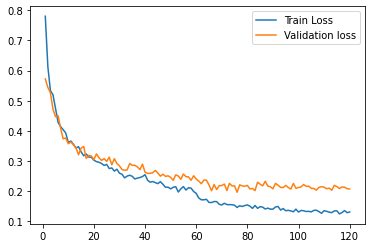

In [19]:
plt.plot(np.arange(1,len(total_train_loss)+1), total_train_loss,label = 'Train Loss')
plt.plot(np.arange(1,len(total_val_loss)+1),total_val_loss, label= 'Validation loss')
plt.legend()
plt.show()

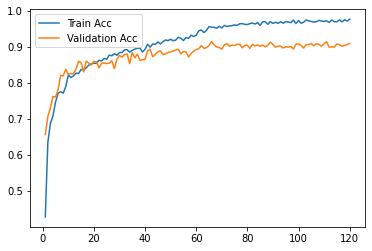

In [20]:
plt.plot(np.arange(1,len(total_train_acc)+1), total_train_acc, label = 'Train Acc')
plt.plot(np.arange(1,len(total_val_acc)+1), total_val_acc, label = 'Validation Acc')
plt.legend()
plt.show()

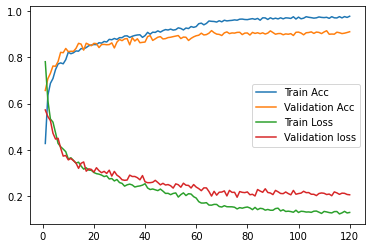

In [21]:
plt.plot(np.arange(1,len(total_train_acc)+1), total_train_acc, label = 'Train Acc')
plt.plot(np.arange(1,len(total_val_acc)+1), total_val_acc, label = 'Validation Acc')
plt.plot(np.arange(1,len(total_train_loss)+1), total_train_loss,label = 'Train Loss')
plt.plot(np.arange(1,len(total_val_loss)+1),total_val_loss, label= 'Validation loss')
plt.legend()
plt.show()

### Test Accuracy

In [22]:

# define batch size for testing
test_batch_size = 64
# create dataloader for validation set
test_triplet_dataset = FaceDataset(df = val_df, num_sample = 3000)
test_triplet_dataloader = DataLoader(test_triplet_dataset, batch_size=test_batch_size, shuffle=True, pin_memory=True)

  0%|          | 0/3000 [00:00<?, ?it/s]

In [23]:
# define path
weights_path = './weights/best_triplet.pth'

triplet_model.to(device)
# load model weights
triplet_model.load_state_dict(torch.load(weights_path))

overall_acc = list()

# set mode for testing
triplet_model.eval()
with torch.no_grad():
    for anchor_img, pos_img, neg_img in tqdm(test_triplet_dataloader):

        threshold_list = np.full(anchor_img.shape[0], model_config['margin'])
        is_same = np.full(anchor_img.shape[0], 1)

        pos_dist_list = list()
        model_output = list()

        anchor_img = anchor_img.to(device)
        pos_img = pos_img.to(device)
        neg_img = neg_img.to(device)
        # compute the out in eval mode
        anchor_img, pos_img, neg_img = triplet_model(anchor_img, pos_img, neg_img)
        # compute loss in eval mode
        loss = criterion(anchor_img, pos_img, neg_img)

        distance_positive = (anchor_img - pos_img).pow(2).sum(1)
        distance_negative = (anchor_img - neg_img).pow(2).sum(1)
        # print((distance_negative-distance_positive>0).sum()*1.0 / distance_negative.size()[0])
        # print(distance_positive.cpu().data.numpy())
        acc = calculate_accuracy(threshold_list,distance_positive.cpu().data.numpy(),is_same)
        overall_acc.append(acc)
    
print(f'Train Accuracy: {np.array(overall_acc).mean()}')


  0%|          | 0/47 [00:00<?, ?it/s]

Train Accuracy: 0.931420972644377


In [24]:
torch.cuda.empty_cache()